# Examples on `Zonasi Negara Singanesia` Problem

https://tlx.toki.id/problems/compfest-12-jcpc-final/C

In [1]:
from itertools import product
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.spatial import KDTree
from time import time

os.chdir('..')

%load_ext autoreload
%autoreload 2

In [2]:
from algen.trainer import Trainer
from algen.chromosome import RealNumberChromosome, Chromosome
from algen.crossover import TwoPointCrossover, Crossover
from algen.mutation import SwapMutation, RadiusMutation, Mutation
from algen.selection import TournamentSelection
from algen.callbacks import Callback

In [3]:
def read_test_case(filename):
    path = f'examples/sample_data/jcpc-12-final-zonasi/{filename}.in'

    with open(path, 'r') as file:
        data = file.readlines()

    num_students, num_schools = map(int, data[0].strip().split())

    stud_coords = []
    for i in range(1, num_students + 1):
        point = data[i].strip().split()
        stud_coords.append(tuple(map(float, point)))
    stud_coords = np.array(stud_coords)

    cap = []
    for i in range(num_students + 1, num_students + 1 + num_schools):
        cap.append(int(data[i].strip()))
    cap = np.array(cap)

    return num_students, num_schools, stud_coords, cap

In [4]:
num_students, num_schools, stud_coords, cap = read_test_case('jcpc-12-final-zonasi_7_1')
print(num_students, num_schools)
print(stud_coords[:10])
print(cap)

30 4
[[ 1.5992  10.90627]
 [17.7288  36.30589]
 [30.52428 46.35028]
 [ 7.1553   7.50558]
 [21.1043  22.48526]
 [19.85313 39.92812]
 [ 5.29385 29.99781]
 [38.64214 15.04448]
 [ 4.22719 39.71868]
 [35.47365 10.27049]]
[ 5  3 12 10]


# Custom Class

In [45]:
class PointChromosome(Chromosome):
    def __init__(self, length, x_min, y_min, x_max, y_max, **kwargs):
        super().__init__(**kwargs)
        self.length = length
        self.x_min, self.y_min = x_min, y_min
        self.x_max, self.y_max = x_max, y_max
        self.x = RealNumberChromosome(length=length, min_value=x_min, max_value=x_max)
        self.y = RealNumberChromosome(length=length, min_value=y_min, max_value=y_max)

        self.build_genotype(self.x, self.y)

    def build_genotype(self, x, y):
        self.x, self.y = x, y
        self.genotype = np.vstack([self.x.genotype, self.y.genotype]).T

    def __repr__(self):
        repr = ', '.join([
            f'length={self.length}',
            f'x_min={self.x_min}',
            f'y_min={self.y_min}',
            f'x_max={self.x_max}',
            f'y_max={self.y_max}',
        ])
        repr = f'PointChromosome({repr})'
        return repr


class PointCrossover(Crossover):
    def __init__(self):
        super().__init__()
        self.cx = TwoPointCrossover()
        self.cy = TwoPointCrossover()

    def __call__(self, ch1: PointChromosome, ch2: PointChromosome):
        x1, y1 = ch1.genotype[:, 0], ch1.genotype[:, 1]
        x2, y2 = ch2.genotype[:, 0], ch2.genotype[:, 1]

        ch_x1 = RealNumberChromosome(length=ch1.length, min_value=ch1.x.min_value, max_value=ch1.x.max_value)
        ch_y1 = RealNumberChromosome(length=ch1.length, min_value=ch1.y.min_value, max_value=ch1.y.max_value)
        ch_x2 = RealNumberChromosome(length=ch2.length, min_value=ch2.x.min_value, max_value=ch2.x.max_value)
        ch_y2 = RealNumberChromosome(length=ch2.length, min_value=ch2.y.min_value, max_value=ch2.y.max_value)

        ch_x1.build_genotype(x1); ch_y1.build_genotype(y1); ch_x2.build_genotype(x2); ch_y2.build_genotype(y2)
        x1, x2 = self.cx(ch_x1, ch_x2)
        y1, y2 = self.cy(ch_y1, ch_y2)

        ch1_ = PointChromosome(length=ch1.length, x_min=ch1.x_min, y_min=ch1.y_min, x_max=ch2.x_max, y_max=ch2.y_max)
        ch2_ = PointChromosome(length=ch1.length, x_min=ch1.x_min, y_min=ch1.y_min, x_max=ch2.x_max, y_max=ch2.y_max)
        ch1_.build_genotype(x1, y1)
        ch2_.build_genotype(x2, y2)

        return ch1_, ch2_


class PointMutation(Mutation):
    def __init__(self, r_x, r_y, x_min, y_min, x_max, y_max):
        super().__init__()
        self.r_x, self.r_y = r_x, r_y
        self.x_min, self.y_min = x_min, y_min
        self.x_max, self.y_max = x_max, y_max
        self.mx = RadiusMutation(radius=r_x, min_value=x_min, max_value=x_max)
        self.my = RadiusMutation(radius=r_y, min_value=y_min, max_value=y_max)

    def __call__(self, chromosome):
        x, y = chromosome.genotype[:, 0], chromosome.genotype[:, 1]
        ch_x = RealNumberChromosome(
            length=chromosome.length,
            min_value=self.x_min,
            max_value=self.x_max
        )
        ch_y = RealNumberChromosome(
            length=chromosome.length,
            min_value=self.y_min,
            max_value=self.y_max
        )

        ch_x.build_genotype(x)
        ch_y.build_genotype(y)

        ch_x = self.mx(ch_x)
        ch_y = self.my(ch_y)

        ch_ = PointChromosome(
            length=chromosome.length,
            x_min=self.x_min,
            y_min=self.y_min,
            x_max=self.x_max,
            y_max=self.y_max
        )
        ch_.build_genotype(ch_x, ch_y)

        return ch_

    def __repr__(self):
        repr = ', '.join([
            f'r_x={self.r_x}',
            f'r_y={self.r_y}',
            f'x_min={self.x_min}',
            f'x_max={self.x_max}',
            f'y_min={self.y_min}',
            f'y_min={self.y_max}'
        ])
        repr = f'PointMutation({repr})'
        return repr

class PrintEveryPeriod(Callback):
    def __init__(self, period=5, verbose=1):
        self.period = period
        self.verbose = verbose

    def on_generation_begin(self, gen, logs):
        self.start = time()

    def on_generation_end(self, gen, logs):
        self.finish = time()
        self.runtime = self.finish - self.start

        fitness = logs.get('fitness')
        population = logs.get('population')
        best_fitness = fitness.max()
        avg_fitness = fitness.mean()
        best_index = fitness.argmax()
        best = population[best_index]

        if self.verbose >= 1 and gen % self.period == 0:
            msg = ' - '.join([
                f'[Generation {gen}]',
                f'{self.runtime:.2f}s',
                f'best: {best_fitness:.4f}',
                f'avg: {avg_fitness:.4f}'
            ])
            print(msg)

# Utils Function

In [46]:
def get_fitness(num_students, num_schools, stud_coords, cap):
    def fitness(chromosome):
        school_coords = chromosome.genotype
        tree = KDTree(school_coords)

        _, school_for_student = tree.query(stud_coords)
        school_count = np.bincount(school_for_student)

        num_candidates_for_school = np.zeros(num_schools, dtype=int)
        num_candidates_for_school[:len(school_count)] = school_count

        num_stud_without_school = np.maximum(num_candidates_for_school - cap, 0).sum()
        num_stud_with_school = 1. - num_stud_without_school / num_students
        
        return num_stud_with_school    

    return fitness

def write_solution(x, y, filename):
    path = f'examples/sample_data/jcpc-12-final-zonasi/{filename}.out'
    with open(path, 'w') as file:
        for x_, y_ in zip(x, y):
            text = f'{x_} {y_}\n'
            file.write(text)

def solve_test_case(filename, params, verbose=1, report=True, write=True, plot=True):
    num_students, num_schools, stud_coords, cap = read_test_case(filename)
    fitness = get_fitness(num_students, num_schools, stud_coords, cap)

    seed = params.pop('seed')
    np.random.seed(seed)

    (x_min, y_min), (x_max, y_max) = stud_coords.min(axis=0), stud_coords.max(axis=0)
    init_pop = np.array([
        PointChromosome(num_schools, x_min, y_min, x_max, y_max)
        for _ in range(params['pop_size'])
    ])

    radius = params.pop('radius')
    selection = TournamentSelection(tournament_size=5)
    crossover = PointCrossover()
    mutation = PointMutation(radius, radius, x_min, y_min, x_max, y_max)

    num_generations = params.pop('num_generations')
    if report:
        callbacks = [PrintEveryPeriod(period=10)]
    else:
        callbacks = None

    trainer = Trainer(
        chromosome_length=num_schools,
        fitness_function=fitness,
        init_pop=init_pop,
        selection=selection,
        crossover=crossover,
        mutation=mutation,
        seed=seed,
        **params
    )

    history = trainer.run(num_generations=num_generations, verbose=verbose,
        callbacks=callbacks)

    if plot:
        best = history.best_fitness_each_gen()
        average = history.average_fitness_each_gen()

        plt.plot(best, label='best')
        plt.plot(average, label='average')

        plt.grid()
        plt.legend()
        plt.xlabel('Generation')
        plt.title('Fitness value')
        plt.show()

    if write:
        best_solution = history.best_chromosome().genotype
        write_solution(best_solution[:, 0], best_solution[:, 1], filename)

    return history

def grid_search(filename, params_grid):
    grid = list(product(*params_grid.values()))
    
    best_so_far = -float('inf')
    num_trials = len(grid)
    total_runtime = 0
    
    final_result = []

    for trial, params_ in enumerate(grid):
        keys = params_grid.keys()
        params_ = dict(zip(keys, params_))
        params = params_.copy()

        now = time()
        history = solve_test_case(filename=filename, params=params_,
            verbose=0, report=False, write=False, plot=False)
        runtime = time() - now
        total_runtime += runtime

        result = params.copy()
        best = history.best_fitness()
        if best > best_so_far:
            best_so_far = best

        result.update({
            'best_fitness': best,
            'run_time': runtime,
            'trial': trial
        })

        final_result.append(result)

        msg = ' - '.join([
            f'Trial: {trial}/{num_trials}',
            f'runtime: {runtime:.2f}s',
            f'best: {best:.3f}',
            f'best so far: {best_so_far:.3f}'
        ])
        print(msg)

    final_result = pd.DataFrame(final_result)
    print(f'Total runtime: {total_runtime:.2f}s')
    
    return final_result

In [7]:
num_students, num_schools, stud_coords, cap = read_test_case('jcpc-12-final-zonasi_7_1')
print(num_students, num_schools)
print(stud_coords[:10])
print(cap)

30 4
[[ 1.5992  10.90627]
 [17.7288  36.30589]
 [30.52428 46.35028]
 [ 7.1553   7.50558]
 [21.1043  22.48526]
 [19.85313 39.92812]
 [ 5.29385 29.99781]
 [38.64214 15.04448]
 [ 4.22719 39.71868]
 [35.47365 10.27049]]
[ 5  3 12 10]


# TC 1

In [ ]:
filename = 'jcpc-12-final-zonasi_1_1'

params = dict(
    num_generations=1000,
    pop_size=200,
    crossover_rate=0.9,
    mutation_rate=0.3,
    seed=42
)

history = solve_test_case(filename=filename, params=params, verbose=1)


# TC 2

Trial: 0/36 - runtime: 0.53s - best: 0.970 - best so far: 0.970
Trial: 1/36 - runtime: 0.47s - best: 0.970 - best so far: 0.970
Trial: 2/36 - runtime: 0.46s - best: 0.970 - best so far: 0.970
Trial: 3/36 - runtime: 0.46s - best: 0.970 - best so far: 0.970
Trial: 4/36 - runtime: 0.50s - best: 0.970 - best so far: 0.970
Trial: 5/36 - runtime: 0.47s - best: 0.970 - best so far: 0.970
Trial: 6/36 - runtime: 0.49s - best: 0.970 - best so far: 0.970
Trial: 7/36 - runtime: 0.51s - best: 0.920 - best so far: 0.970
Trial: 8/36 - runtime: 0.49s - best: 0.970 - best so far: 0.970
Trial: 9/36 - runtime: 0.50s - best: 0.980 - best so far: 0.980
Trial: 10/36 - runtime: 0.52s - best: 0.980 - best so far: 0.980
Trial: 11/36 - runtime: 0.55s - best: 0.970 - best so far: 0.980
Trial: 12/36 - runtime: 0.94s - best: 0.990 - best so far: 0.990
Trial: 13/36 - runtime: 0.98s - best: 0.960 - best so far: 0.990
Trial: 14/36 - runtime: 0.95s - best: 0.980 - best so far: 0.990
Trial: 15/36 - runtime: 0.97s - bes

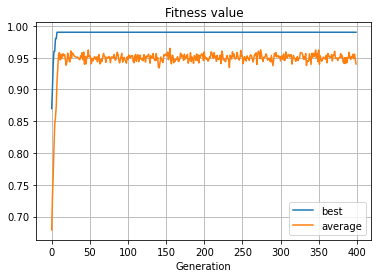

In [49]:
filename = 'jcpc-12-final-zonasi_2_1'

params_grid = dict(
    num_generations=[20],
    pop_size=[100, 200, 300],
    crossover_rate=[0.9],
    mutation_rate=[0.1, 0.2, 0.3, 0.4],
    radius=[0.05, 0.1, 0.2],
    seed=[42]
)

result = grid_search(filename, params_grid)

result = result.sort_values(['best_fitness', 'pop_size', 'run_time'], ascending=[False, True, True])
params = result.iloc[0, :6].to_dict()

params['num_generations'] = 400
params['pop_size'] = int(params['pop_size'])
params['seed'] = int(params['seed'])

print(result.groupby('pop_size')['best_fitness'].describe().T)
print(result.groupby('mutation_rate')['best_fitness'].describe().T)
print(result.groupby('radius')['best_fitness'].describe().T)
print(params)

history = solve_test_case(filename=filename, params=params, verbose=1)



# TC 3

[Generation 0] - 0.22s - best: 0.6225 - avg: 0.5657
[Generation 10] - 0.22s - best: 0.7040 - avg: 0.6786
[Generation 20] - 0.23s - best: 0.7640 - avg: 0.7491
[Generation 30] - 0.23s - best: 0.7890 - avg: 0.7784
[Generation 40] - 0.32s - best: 0.8140 - avg: 0.8034
[Generation 50] - 0.26s - best: 0.8320 - avg: 0.8166
[Generation 60] - 0.28s - best: 0.8355 - avg: 0.8295
[Generation 70] - 0.26s - best: 0.8405 - avg: 0.8326
[Generation 80] - 0.25s - best: 0.8440 - avg: 0.8374
[Generation 90] - 0.26s - best: 0.8450 - avg: 0.8391
Best generation : 91
Best fitness    : 0.847
Best chromosome : array([[  1.        , 246.11373583],
       [  1.        ,   6.05573209],
       [  1.        ,  57.78387769],
       [  1.        , 197.99355837],
       [  1.        , 115.18798375],
       [  1.        , 299.51262861],
       [  1.        , 203.18327496],
       [  1.        , 291.6338677 ],
       [  1.        ,  56.00801713],
       [  1.        , 263.50413307],
       [  1.        ,  98.6589356 ],
 

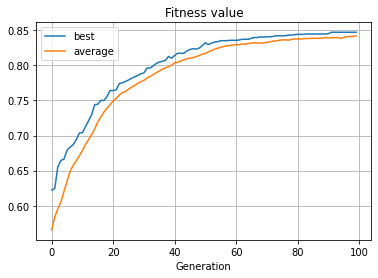

In [10]:
filename = 'jcpc-12-final-zonasi_3_1'

params_grid = dict(
    num_generations=[200],
    pop_size=[100, 200, 300],
    crossover_rate=[0.9],
    mutation_rate=[0.1, 0.2, 0.3, 0.4],
    radius=[0.05, 0.1, 0.2],
    seed=[42]
)

result = grid_search(filename, params_grid)

result = result.sort_values(['best_fitness', 'pop_size', 'run_time'], ascending=[False, True, True])
params = result.iloc[0, :6].to_dict()

params['num_generations'] = 400
params['pop_size'] = int(params['pop_size'])
params['seed'] = int(params['seed'])

print(result.groupby('pop_size')['best_fitness'].describe().T)
print(result.groupby('mutation_rate')['best_fitness'].describe().T)
print(result.groupby('radius')['best_fitness'].describe().T)
print(params)

history = solve_test_case(filename=filename, params=params, verbose=1)


# TC 4

[Generation 0] - 0.05s - best: 0.9400 - avg: 0.7866
[Generation 10] - 0.06s - best: 1.0000 - avg: 0.9915
[Generation 20] - 0.06s - best: 1.0000 - avg: 0.9909
[Generation 30] - 0.07s - best: 1.0000 - avg: 0.9934
[Generation 40] - 0.06s - best: 1.0000 - avg: 0.9903
Best generation : 3
Best fitness    : 1.0
Best chromosome : array([[ 31.13363088, 164.85134121],
       [165.5665191 , 119.01670059],
       [ 59.35746647,  44.06239365],
       [152.21419041,  50.96438393],
       [133.21586378, 151.7417736 ]])
Finished in 0:00:03 (avg 0.06s/generation)


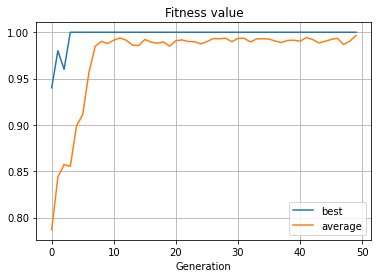

In [11]:
filename = 'jcpc-12-final-zonasi_4_1'

params = dict(
    num_generations=50,
    pop_size=200,
    crossover_rate=0.9,
    mutation_rate=0.3,
    seed=42,
    radius=0.1
)

history = solve_test_case(filename=filename, params=params, verbose=1)


# TC 5

[Generation 0] - 0.10s - best: 0.8320 - avg: 0.7444
[Generation 10] - 0.10s - best: 0.9040 - avg: 0.8604
[Generation 20] - 0.09s - best: 0.9400 - avg: 0.9171
[Generation 30] - 0.11s - best: 0.9520 - avg: 0.9389
[Generation 40] - 0.11s - best: 0.9580 - avg: 0.9445
[Generation 50] - 0.09s - best: 0.9660 - avg: 0.9530
[Generation 60] - 0.09s - best: 0.9680 - avg: 0.9556
[Generation 70] - 0.09s - best: 0.9700 - avg: 0.9586
[Generation 80] - 0.10s - best: 0.9700 - avg: 0.9572
[Generation 90] - 0.10s - best: 0.9700 - avg: 0.9577
[Generation 100] - 0.10s - best: 0.9700 - avg: 0.9588
[Generation 110] - 0.09s - best: 0.9720 - avg: 0.9592
[Generation 120] - 0.10s - best: 0.9740 - avg: 0.9603
[Generation 130] - 0.09s - best: 0.9740 - avg: 0.9611
[Generation 140] - 0.10s - best: 0.9740 - avg: 0.9621
[Generation 150] - 0.10s - best: 0.9740 - avg: 0.9603
[Generation 160] - 0.10s - best: 0.9740 - avg: 0.9629
[Generation 170] - 0.10s - best: 0.9740 - avg: 0.9610
[Generation 180] - 0.11s - best: 0.9740

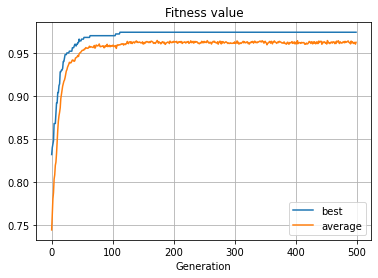

In [12]:
filename = 'jcpc-12-final-zonasi_5_1'

params_grid = dict(
    num_generations=[200],
    pop_size=[100, 200, 300],
    crossover_rate=[0.9],
    mutation_rate=[0.1, 0.2, 0.3, 0.4],
    radius=[0.05, 0.1, 0.2],
    seed=[42]
)

result = grid_search(filename, params_grid)

result = result.sort_values(['best_fitness', 'pop_size', 'run_time'], ascending=[False, True, True])
params = result.iloc[0, :6].to_dict()

params['num_generations'] = 400
params['pop_size'] = int(params['pop_size'])
params['seed'] = int(params['seed'])

print(result.groupby('pop_size')['best_fitness'].describe().T)
print(result.groupby('mutation_rate')['best_fitness'].describe().T)
print(result.groupby('radius')['best_fitness'].describe().T)
print(params)

history = solve_test_case(filename=filename, params=params, verbose=1)


# TC 6

[Generation 0] - 0.49s - best: 1.0000 - avg: 0.9283
[Generation 10] - 1.02s - best: 1.0000 - avg: 0.9799
[Generation 20] - 0.87s - best: 1.0000 - avg: 0.9867
[Generation 30] - 0.53s - best: 1.0000 - avg: 0.9858
[Generation 40] - 0.49s - best: 1.0000 - avg: 0.9856
Best generation : 0
Best fitness    : 1.0
Best chromosome : array([[185.46768099, 208.57765156],
       [293.49456078, 896.89708452]])
Finished in 0:00:31 (avg 0.62s/generation)


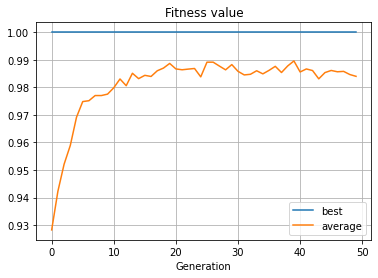

In [13]:
filename = 'jcpc-12-final-zonasi_6_1'

params = dict(
    num_generations=50,
    pop_size=200,
    crossover_rate=0.9,
    mutation_rate=0.3,
    seed=42,
    radius=0.1
)

history = solve_test_case(filename=filename, params=params, verbose=1)


# TC 7

[Generation 0] - 0.06s - best: 0.9667 - avg: 0.8107
[Generation 10] - 0.07s - best: 1.0000 - avg: 0.9552
[Generation 20] - 0.07s - best: 1.0000 - avg: 0.9720
[Generation 30] - 0.08s - best: 1.0000 - avg: 0.9705
[Generation 40] - 0.06s - best: 1.0000 - avg: 0.9685
Best generation : 2
Best fitness    : 1.0
Best chromosome : array([[13.95110117, 49.77536   ],
       [44.32599618, 40.3180416 ],
       [ 3.20892332, 33.60227181],
       [47.7827    ,  7.29142507]])
Finished in 0:00:03 (avg 0.06s/generation)


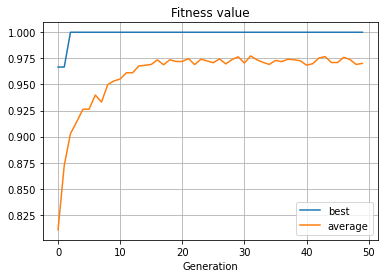

In [14]:
filename = 'jcpc-12-final-zonasi_7_1'

params = dict(
    num_generations=50,
    pop_size=200,
    crossover_rate=0.9,
    mutation_rate=0.3,
    seed=42,
    radius=0.1
)

history = solve_test_case(filename=filename, params=params, verbose=1)


# TC 8

[Generation 0] - 0.10s - best: 0.7600 - avg: 0.6566
[Generation 10] - 0.08s - best: 0.9300 - avg: 0.8913
[Generation 20] - 0.09s - best: 0.9600 - avg: 0.9399
[Generation 30] - 0.09s - best: 0.9750 - avg: 0.9622
[Generation 40] - 0.10s - best: 0.9800 - avg: 0.9622
[Generation 50] - 0.08s - best: 0.9800 - avg: 0.9676
[Generation 60] - 0.11s - best: 0.9800 - avg: 0.9655
[Generation 70] - 0.09s - best: 0.9850 - avg: 0.9656
[Generation 80] - 0.09s - best: 0.9850 - avg: 0.9698
[Generation 90] - 0.09s - best: 0.9850 - avg: 0.9683
[Generation 100] - 0.08s - best: 0.9850 - avg: 0.9719
[Generation 110] - 0.08s - best: 0.9850 - avg: 0.9709
[Generation 120] - 0.08s - best: 0.9850 - avg: 0.9692
[Generation 130] - 0.07s - best: 0.9850 - avg: 0.9706
[Generation 140] - 0.07s - best: 0.9850 - avg: 0.9721
[Generation 150] - 0.09s - best: 0.9850 - avg: 0.9709
[Generation 160] - 0.07s - best: 0.9850 - avg: 0.9705
[Generation 170] - 0.11s - best: 0.9850 - avg: 0.9715
[Generation 180] - 0.10s - best: 0.9850

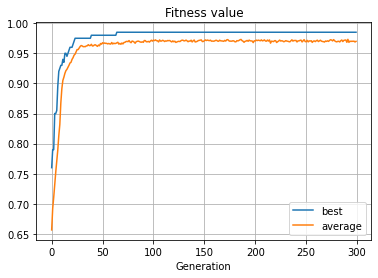

In [15]:
filename = 'jcpc-12-final-zonasi_8_1'

params_grid = dict(
    num_generations=[200],
    pop_size=[100, 200, 300],
    crossover_rate=[0.9],
    mutation_rate=[0.1, 0.2, 0.3, 0.4],
    radius=[0.05, 0.1, 0.2],
    seed=[42]
)

result = grid_search(filename, params_grid)

result = result.sort_values(['best_fitness', 'pop_size', 'run_time'], ascending=[False, True, True])
params = result.iloc[0, :6].to_dict()

params['num_generations'] = 400
params['pop_size'] = int(params['pop_size'])
params['seed'] = int(params['seed'])

print(result.groupby('pop_size')['best_fitness'].describe().T)
print(result.groupby('mutation_rate')['best_fitness'].describe().T)
print(result.groupby('radius')['best_fitness'].describe().T)
print(params)

history = solve_test_case(filename=filename, params=params, verbose=1)



# TC 9

[Generation 0] - 1.45s - best: 0.6651 - avg: 0.6252
[Generation 10] - 1.39s - best: 0.7039 - avg: 0.6922
[Generation 20] - 1.43s - best: 0.7367 - avg: 0.7290
[Generation 30] - 1.46s - best: 0.7577 - avg: 0.7492
[Generation 40] - 1.20s - best: 0.7747 - avg: 0.7679
[Generation 50] - 1.19s - best: 0.7869 - avg: 0.7823
[Generation 60] - 1.26s - best: 0.8022 - avg: 0.7962
[Generation 70] - 1.50s - best: 0.8127 - avg: 0.8073
[Generation 80] - 1.41s - best: 0.8207 - avg: 0.8162
[Generation 90] - 1.45s - best: 0.8261 - avg: 0.8226
[Generation 100] - 1.42s - best: 0.8299 - avg: 0.8266
[Generation 110] - 1.40s - best: 0.8377 - avg: 0.8323
[Generation 120] - 1.46s - best: 0.8407 - avg: 0.8369
[Generation 130] - 1.40s - best: 0.8466 - avg: 0.8422
[Generation 140] - 1.19s - best: 0.8510 - avg: 0.8474
[Generation 150] - 1.20s - best: 0.8544 - avg: 0.8504
[Generation 160] - 1.19s - best: 0.8570 - avg: 0.8533
[Generation 170] - 1.36s - best: 0.8601 - avg: 0.8569
[Generation 180] - 1.48s - best: 0.8639

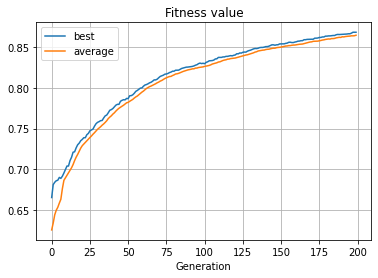

In [16]:
filename = 'jcpc-12-final-zonasi_9_1'

params = dict(
    num_generations=200,
    pop_size=200,
    crossover_rate=0.9,
    mutation_rate=0.3,
    seed=42,
    radius=0.1
)

history = solve_test_case(filename=filename, params=params, verbose=1)


# TC 10

[Generation 0] - 5.18s - best: 0.5357 - avg: 0.5188
[Generation 10] - 4.92s - best: 0.5566 - avg: 0.5511
[Generation 20] - 5.90s - best: 0.5717 - avg: 0.5680
[Generation 30] - 5.74s - best: 0.5816 - avg: 0.5782
[Generation 40] - 4.12s - best: 0.5957 - avg: 0.5917
[Generation 50] - 5.05s - best: 0.6055 - avg: 0.6029
[Generation 60] - 4.93s - best: 0.6134 - avg: 0.6107
[Generation 70] - 4.99s - best: 0.6217 - avg: 0.6188
[Generation 80] - 4.15s - best: 0.6328 - avg: 0.6292
[Generation 90] - 4.73s - best: 0.6403 - avg: 0.6386
Best generation : 98
Best fitness    : 0.6456
Best chromosome : array([[472.14271457, 523.80116378],
       [629.58049437, 999.91474   ],
       [101.15304946, 814.26446826],
       ...,
       [952.9521406 , 392.56818636],
       [408.73547651, 209.05802236],
       [148.0963782 , 876.93776003]])
Finished in 0:08:13 (avg 4.93s/generation)


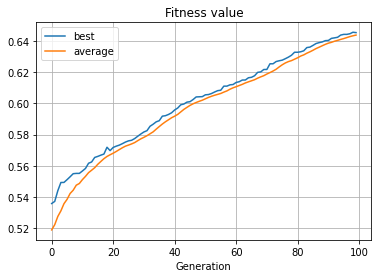

In [17]:
filename = 'jcpc-12-final-zonasi_10_1'

params = dict(
    num_generations=50,
    pop_size=200,
    crossover_rate=0.9,
    mutation_rate=0.3,
    seed=42,
    radius=0.1
)

history = solve_test_case(filename=filename, params=params, verbose=1)
